In [19]:
import pandas as pd
import numpy as np
import os
import math

## 引用 MHCflurry 文献的标准化代码
def from_ic50(ic50, max_ic50=50000.0):
    """
    Convert ic50s to regression targets in the range [0.0, 1.0].
    
    Parameters
    ----------
    ic50 : numpy.array of float
    Returns
    -------
    numpy.array of float
    """
    x = 1.0 - (np.log(np.maximum(ic50, 1e-12)) / np.log(max_ic50))
    
    return np.minimum(
        1.0,
        np.maximum(0.0, x))

def to_ic50(x, max_ic50=50000.0):
    return max_ic50 ** (1.0 - x)

获得PK-3的基准数据集。

In [29]:
# txt_dir = '/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data/txt/class-II_15mer'
# csv_dir = '/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data'
# for file in os.listdir(txt_dir):
# # 对于 class-I
#     file_name = file.replace('%2A','_')
#     file_name = file_name.replace('%3A','')
#     file_name = file_name.replace('txt','csv')
    
# # # 对于 class-II
# #     file_values = file.split('-')
# #     if len(file_values) == 3:
# #         # 在allele中插入‘_’
# #         file_value1 = list(file_values[1])
# #         file_value1.insert(4,'_')           #在第一个allele的第5位插入'_'
# #         file_value1 = ''.join(file_value1)

# #         file_value2 = list(file_values[2])
# #         file_value2.insert(4,'_')           #在第二个allele的第5位插入'_'
# #         file_value2 = ''.join(file_value2)

# #         file_name = file_values[0] + '-' + file_value1 + '&' + file_value2
# #         file_name = file_name.replace('txt','csv')

# #     if len(file_values) == 2:
# #         # 在allele中插入‘_’
# #         file_value1 = list(file_values[1])
# #         file_value1.insert(4,'_')           #在第一个allele的第5位插入'_'
# #         file_value1 = ''.join(file_value1)

# #         file_name = file_values[0] + '-' + file_value1
# #         file_name = file_name.replace('txt','csv')

#     # 获得基准数据集的csv文件。  
#     ls_out=[]
    
#     #打开并整理文件
#     with open(os.path.join(txt_dir,file),'r')as df_in:
#         #读每一行
#         for line in df_in:
#             ls_in = line.strip().split('\t')    #".strip()",清除前后空格
#             ls_out.append(ls_in)
            
#     df_in.close()

#     #生成dataframe,加入标准化的QM值
#     df_out = pd.DataFrame(ls_out)
#     df_out.columns = ['Description','Quantitative measurement(nm)']
#     # 将'Quantitative measurement(nm)'列的数据类型转换为“float”
#     def format(value):
#         value = float(value)
#         return value
#     df_out['Quantitative measurement(nm)'] = df_out['Quantitative measurement(nm)'].apply(format)
#     # 数据标准化 【1-log10(IC50)/log10(50000 nM)】 ,IC50单位为nM
#     df_out["Normalized_QM"] =  1-(df_QM["Quantitative measurement"].apply(np.log10))/np.log10(50000)

#     #储存文件
#     df_out.to_csv(os.path.join(csv_dir,file_name),index=0) 

获得PK-3训练集数据--
    "trainval_MID.no_MS" - "benchmark data"，即测试集数据不在训练集中暴露。

In [11]:
oritrainval_dir = '/raid/hly/Dopaap predictor/data/trainval_MID.no_MS'
benchmark_dir = '/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data'
trainval_dir = '/raid/hly/PK-3[2018PLOS]/data/trainval_MID.no_MS(for_PK3)'

for file in os.listdir(oritrainval_dir):
    if os.path.exists(os.path.join(benchmark_dir,file)) :

    ## 分别处理训练数据和测试数据，以便能求差值
        df_test = pd.read_csv(os.path.join(benchmark_dir,file))
        df_test.rename(
                columns={"Description": "peptide", "Quantitative measurement(nm)": "measurement_value", "Normalized_QM": "Normalized_QM"},
                inplace=True)
        # 数据标准化 
        df_test["Normalized_QM"] = df_test["measurement_value"].apply(from_ic50)
        # 保存文件
        df_test.to_csv(os.path.join(benchmark_dir,file),index=0)
        
        df_trainval = pd.read_csv(os.path.join(oritrainval_dir,file),index_col=0)
        df_trainval = df_trainval[['peptide','measurement_value','Normalized_QM']]

#### 求差集

        diff_df = pd.concat([df_trainval, df_test, df_test]).drop_duplicates(subset='peptide',keep=False)

        diff_df.to_csv(os.path.join(trainval_dir,file),index=0)
        

In [4]:
### 备注：
# "HLA-A*15:03"数据集在使用from_ic50()进行标准化后，Normalized_QM全是1.0，导致无法计算R2.
# 因此，对其采用【1-log10(IC50)/log10(50000 nM)】的标准化公式，这样Normalized_QM最大值会稍大于1.

dft = pd.read_csv('/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data/HLA-B_1503.csv')
# 数据标准化 【1-log10(IC50)/log10(50000 nM)】 ,IC50单位为nM
dft["Normalized_QM"] = 1-(dft["measurement_value"].apply(np.log10))/np.log10(50000)
dft.to_csv('/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data/HLA-B_1503.csv')

In [29]:
# 将训练验证集恢复至原来信息量
oritrainval_dir = '/raid/hly/Dopaap predictor/data/trainval_MID.no_MS'
trainval_dir = '/raid/hly/PK-3[2018PLOS]/data/trainval_MID.no_MS(for_PK3)'

for file in os.listdir(trainval_dir):
        # 将 “peptide” 列设为索引
        df_oritv = pd.read_csv(os.path.join(oritrainval_dir,file))
        df_oritv.set_index('peptide',inplace=True)

        df_tv = pd.read_csv(os.path.join(trainval_dir,file))
        df_tv.set_index('peptide',inplace=True)

        df = pd.merge(df_oritv,df_tv,how='inner',left_index=True,right_index=True)
        df = df.iloc[:,:-2]
        df.rename(
                columns={"measurement_value_x": "measurement_value", "Normalized_QM_x": "Normalized_QM"},
                inplace=True)
        df.to_csv(os.path.join(trainval_dir,file))

数据统计

In [12]:
import pandas as pd
#统计了各数据集的条目数，多肽长度的最值，活性值最值，标准化活性值的最值。

files_dir = '/raid/hly/PK-3[2018PLOS]/data/trainval_MID.no_MS(for_PK3)'
files = os.listdir(files_dir)
statistic = []
for file in files:
    df = pd.read_csv(os.path.join(files_dir,file))
    file_name = file.split('.')[0]
    # 条目数
    pep_num = len(df)

    #多肽长度范围
    pep_len_min = min(map(len,df['peptide']))
    pep_len_max = max(map(len,df['peptide']))

    #QM范围
    QM_min = min(df['measurement_value'])
    QM_max = max(df['measurement_value'])
    
    #normalized_QM范围
    Normalized_QM_min = min(df['Normalized_QM'])
    Normalized_QM_max = max(df['Normalized_QM'])

    statistic.append([file_name,pep_num,pep_len_min,pep_len_max,QM_min,QM_max,Normalized_QM_min,Normalized_QM_max])
df_stt = pd.DataFrame(statistic,columns=['HLA-allele','pep_num','pep_len_min','pep_len_max','QM_min','QM_max','Normalized_QM_min','Normalized_QM_max'])
df_stt.sort_values(by='pep_num',axis=0,ascending=False, inplace=True)
df_stt = df_stt.reset_index(drop = True)
df_stt.to_csv('/raid/hly/PK-3[2018PLOS]/data/statistics/stat_trainval230412.csv')

计算测试集结果

In [1]:
import pandas as pd
import numpy as np
import os
import math
import scipy.stats
def PCC(y_pred,y_true):
    diff_pred,diff_true=y_pred-np.mean(y_pred),y_true-np.mean(y_true)
    return np.sum(diff_pred*diff_true)/np.sqrt(np.sum(diff_pred**2)*np.sum(diff_true**2))

In [3]:
alldata_res = {}

res_files = '/raid/hly/PK-3[2018PLOS]/Res_V1'
for Allele in os.listdir(res_files):
    # print(Allele)
    res_file = pd.read_csv(os.path.join(res_files,Allele) + '/results/' + Allele +'_V1_results.csv',index_col=0)
    alldata_res[Allele] = res_file.iloc[0]
    df_alldata_res = pd.DataFrame(alldata_res).T

df_alldata_res.to_csv('/raid/hly/PK-3[2018PLOS]/pred_true/results_noMS_V1.csv')

In [6]:
# 拼接基准测试集的预测结果
res_files = '/raid/hly/PK-3[2018PLOS]/Res_V1'
df_allpred = pd.DataFrame()
for Allele in os.listdir(res_files):
    pred_file = pd.read_csv(os.path.join(res_files,Allele) + '/' + Allele +'true_pred.csv',index_col=0)
    pred_file['Allele'] = Allele 
    df_allpred = df_allpred.append(pred_file)
df_allpred.to_csv('/raid/hly/PK-3[2018PLOS]/pred_true/predresults_noMS_V1.csv',index=0)

In [ ]:
df_allpred = pd.read_csv('/raid/hly/PK-3[2018PLOS]/no_spec_mass/pred_true/predresults_noMS_1.csv')
df_allpred

In [7]:
# 计算R2
from sklearn.metrics import r2_score
import pandas as pd
# df_allpred_1 = pd.read_csv('/raid/hly/PK-3[2018PLOS]/2ndexpt(trainvaltest)/predresults_class1_2nd.csv')

y_true = df_allpred['Normalized_QM'].to_list()
y_pred = df_allpred['Pred_Norm_QM'].to_list()
r2_score(y_true, y_pred)

0.5536638192219083

Text(0, 0.5, 'y_true')

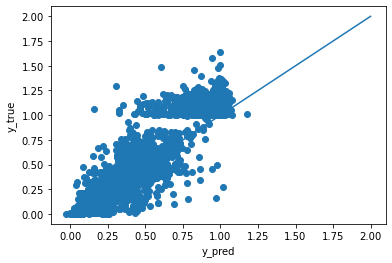

In [8]:
import matplotlib.pyplot as plt

plt.scatter(y_true,y_pred)
#plt.title('测试集活性值的预测值与真实值')
x = np.linspace(0, 2)
plt.plot(x, x)
plt.xlabel('y_pred')
plt.ylabel('y_true')
# plt.savefig

In [6]:
# 计算 Pearson r
y_true = df_allpred['Normalized_QM'].to_list()
y_pred = df_allpred['Pred_Norm_QM'].to_list()
PCC(y_true, y_pred)

0.9267466225335701

In [7]:
# 计算 tau
y_true = df_allpred['Normalized_QM'].to_list()
y_pred = df_allpred['Pred_Norm_QM'].to_list()
scipy.stats.kendalltau(y_pred, y_true)[0]

0.7200475522377997